# Cardiac Pathology Prediction - IMA205 Challenge 2023

The goal of this challenge is to classify MRI images of the heart among five different diagnostic classes:

    1. Healthy controls
    2. Myocardial infarction
    3. Dilated cardiomyopathy
    4. Hypertrophic cardiomyopathy
    5. Abnormal right ventricle

In order to do so, you will extract features such as the volume of the anatomical structures at two different time points in the cardiac cycle (end of the cardiac contraction and end of the dilation), the thickness of the cardiac muscle, and the ejection fractions. After that, you will use machine learning algorithms to classify the subjects.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import skimage as ski

In [2]:
# !pip install -q nibabel
import nibabel as nib

You should consider upgrading via the '/home/kr0pt/Documents/Documentos/Telecom/IMA/ima_venv/bin/python3 -m pip install --upgrade pip' command.


In [8]:
#data_dir = '/content/drive/MyDrive/TELECOM/IMA205/Challenge'
data_dir ='./ima205-challenge-2023'

## Step1: Understanding data

### metadata

In [9]:
#loading the metaData
TrainMetaData = pd.read_csv(data_dir + '/metaDataTrain.csv')
TestMetaData = pd.read_csv(data_dir + '/metaDataTest.csv')

In [10]:
TrainMetaData.head(3)

,Id,Category,Height,Weight
0,1,2,184.0,95.0
1,2,2,160.0,70.0
2,3,2,165.0,77.0


### image train data

In [11]:
def plot_seg_imgs(ED, ED_seg, ES, ES_seg):
    '''
    This function will plot segmented heart image 
    with it's respectives non-segmented

    inputs:

    outputs:
    '''

    fig, ax = plt.subplots(2, 2, figsize=(8,8))

    ax[0,0].set_title("Systole")
    ax[0,0].imshow(ES)
    ax[0,1].set_title("Systole segmentation")
    ax[0,1].imshow(ES_seg)

    ax[1,0].set_title("Diastole")
    ax[1,0].imshow(ED)
    ax[1,1].set_title("Diastole segmentation")           
    ax[1,1].imshow(ED_seg)


In [12]:
# loading diastole and diastole segmentation sample 
ED_atlas_train = nib.load(data_dir + '/Train/001/001_ED.nii')
ED_atlas_train_seg = nib.load(data_dir + '/Train/001/001_ED_seg.nii')

# loading systole sample and systole segmentation sample
ES_atlas_train = nib.load(data_dir + '/Train/001/001_ES.nii')
ES_atlas_train_seg = nib.load(data_dir + '/Train/001/001_ES_seg.nii')

# getting only the image information (memmap)
ED_train = ED_atlas_train.get_fdata()
ED_seg_train = ED_atlas_train_seg.get_fdata()
ES_train = ES_atlas_train.get_fdata()
ES_seg_train = ES_atlas_train_seg.get_fdata()

# seeing the shape
print(f'Diastole shape: {ED_train.shape}')
print(f'Diastole segmented shape: {ED_seg_train.shape}')
print(f'Systole shape: {ES_train.shape}')
print(f'Systole segmented shape: {ED_seg_train.shape}')

Diastole shape: (216, 256, 10)
Diastole segmented shape: (216, 256, 10)
Systole shape: (216, 256, 10)
Systole segmented shape: (216, 256, 10)


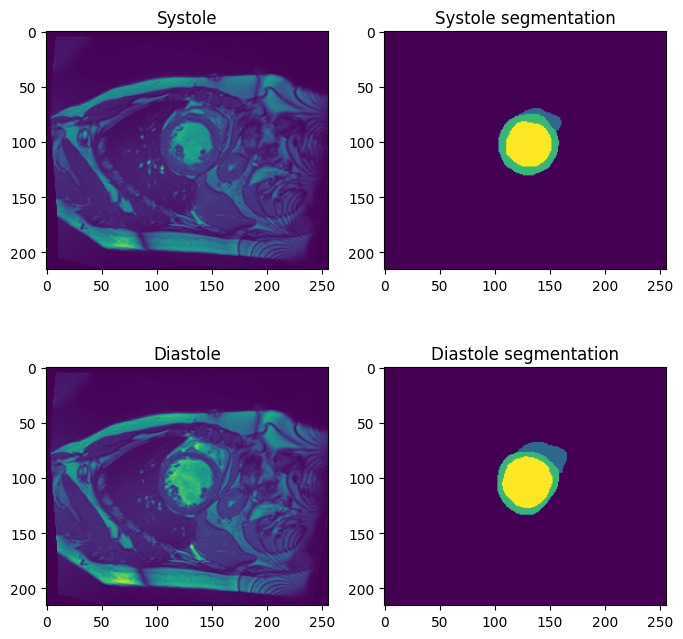

In [13]:
idx = 5

ES_train_slice = ED_train[:,:,idx]
ES_seg_train_slice = ED_seg_train[:,:,idx]
ED_train_slice = ES_train[:,:,idx]
ED_seg_train_slice = ES_seg_train[:,:,idx]

plot_seg_imgs(ES_train_slice, ES_seg_train_slice, ED_train_slice, ED_seg_train_slice)

Here 

    0. Background
    1. Right ventricle cavity
    2. Myocardium
    3. Left ventricle cavity


In [14]:
labels = ['Background', 'Right ventricle cavity', 'Myocardium', 'Left ventricle cavity']

In [15]:
# We can see each level of segmentation
def seg_level(ES_seg, ED_seg, n_levels=10, legend=["Systole segmentation","Diastole segmentation"]):
    fig, ax = plt.subplots(n_levels, 2, figsize=(8,n_levels*4))
    for i in range(n_levels):
        ax[i,0].set_title(legend[0])
        ax[i,0].imshow(ES_seg[:,:,i])
        ax[i,1].set_title(legend[1])          
        ax[i,1].imshow(ED_seg[:,:,i])

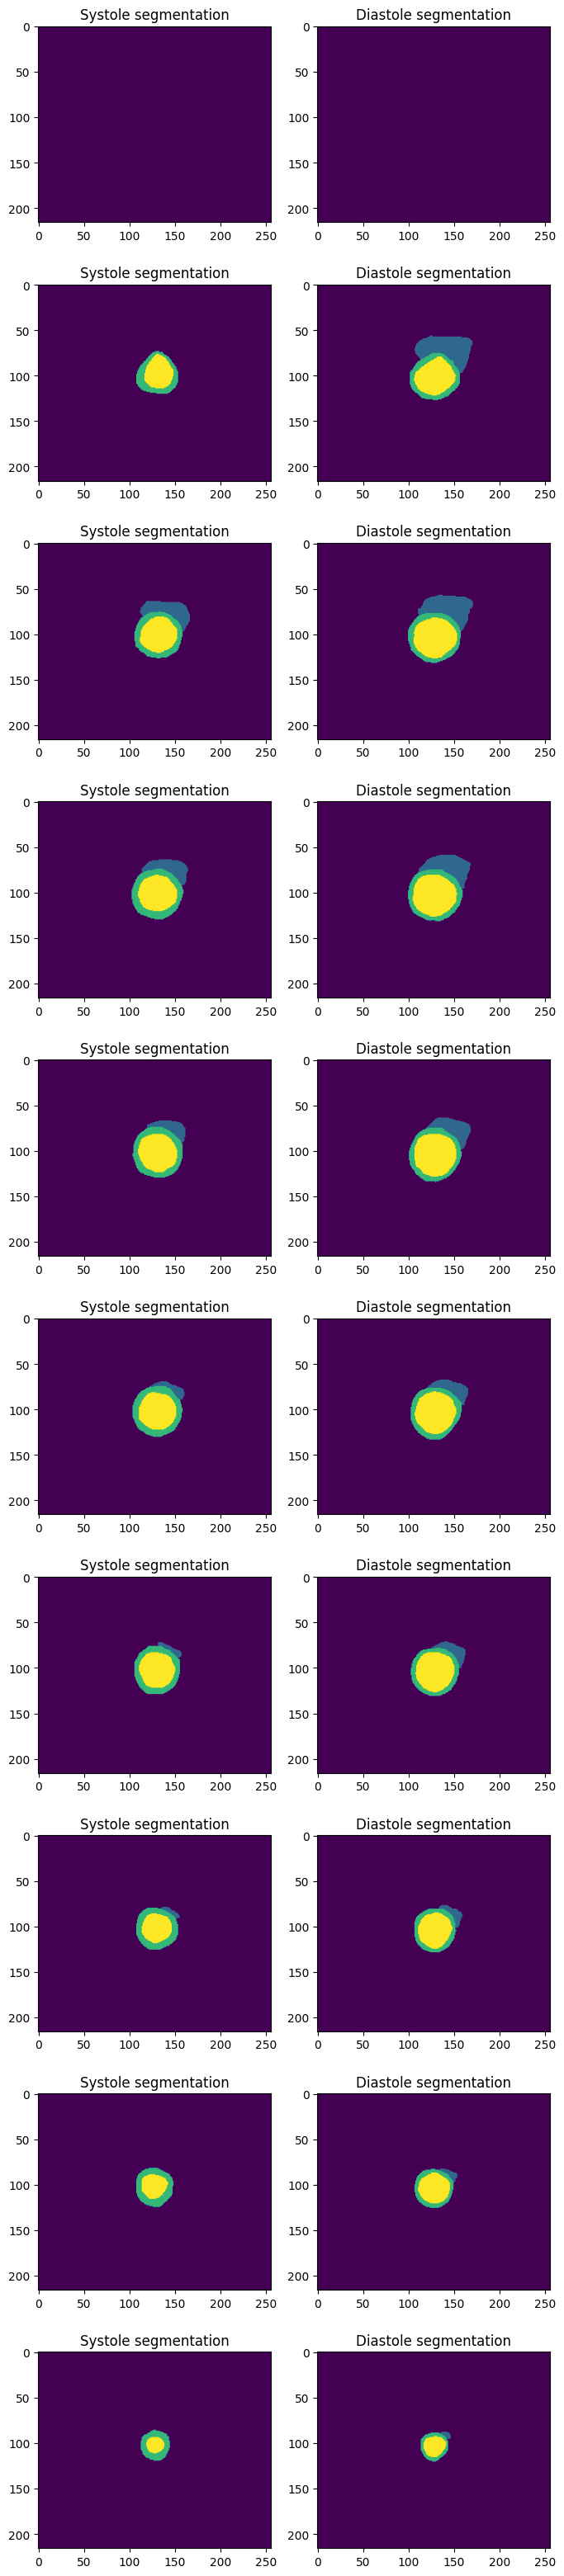

In [16]:
seg_level(ES_seg_train, ED_seg_train)

### image test data

In [17]:
# loading diastole and diastole segmentation sample 
ED_atlas_test = nib.load(data_dir + '/Test/101/101_ED.nii')
ED_atlas_test_seg = nib.load(data_dir + '/Test/101/101_ED_seg.nii')

# loading systole sample and systole segmentation sample
ES_atlas_test = nib.load(data_dir + '/Test/101/101_ES.nii')
ES_atlas_test_seg = nib.load(data_dir + '/Test/101/101_ES_seg.nii')

# getting only the image information (array)
ED_test = ED_atlas_test.get_fdata()
ED_seg_test = ED_atlas_test_seg.get_fdata()
ES_test = ES_atlas_test.get_fdata()
ES_seg_test = ES_atlas_test_seg.get_fdata()

# seeing the shape
print(f'Diastole shape: {ED_test.shape}')
print(f'Diastole segmented shape: {ED_seg_test.shape}')
print(f'Systole shape: {ES_test.shape}')
print(f'Systole segmented shape: {ES_seg_test.shape}')

Diastole shape: (256, 216, 10)
Diastole segmented shape: (256, 216, 10)
Systole shape: (256, 216, 10)
Systole segmented shape: (256, 216, 10)


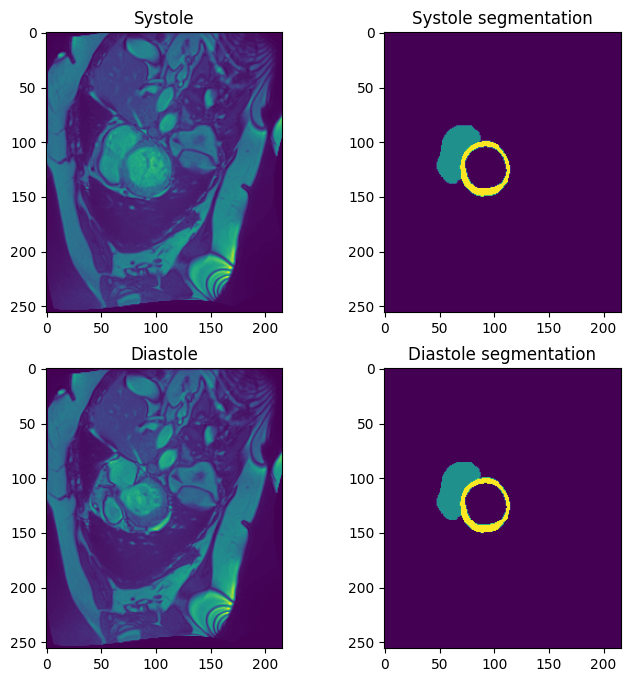

In [18]:
idx = 1

ES_test_slice = ES_test[:,:,idx]
ES_seg_test_slice = ED_seg_test[:,:,idx]
ED_test_slice = ED_test[:,:,idx]
ED_seg_test_slice = ED_seg_test[:,:,idx]

plot_seg_imgs(ES_test_slice, ES_seg_test_slice, ED_test_slice, ED_seg_test_slice)

Here 

    0. Background
    1. Right ventricle cavity
    2. Myocardium
    3. -

without Left ventricle cavity

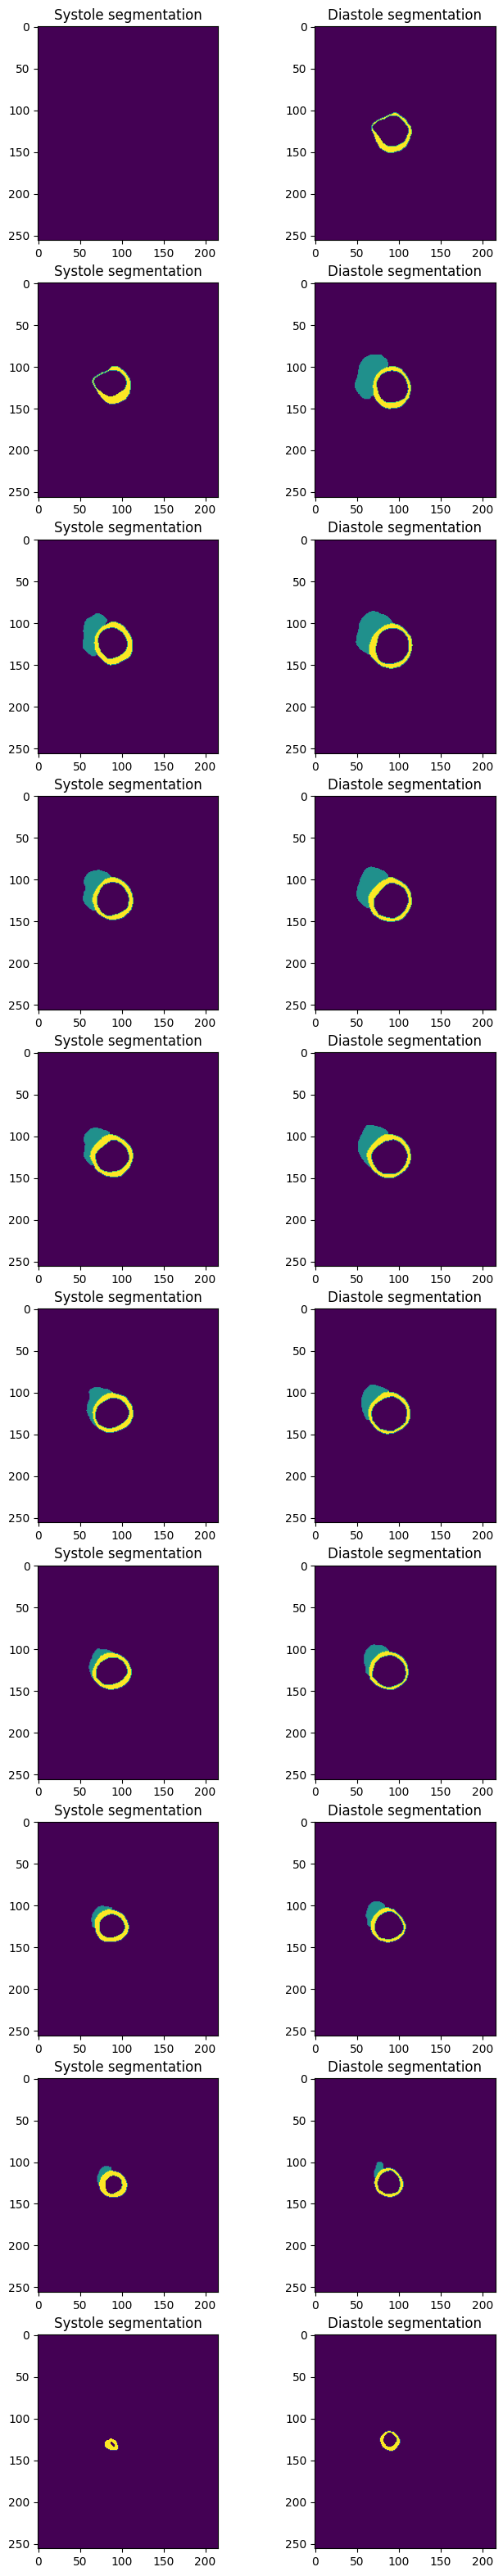

In [19]:
seg_level(ES_seg_test, ED_seg_test)

## Feature Extraction

We'll try to do as feature extraction

- Perimeter of Myocardium, left ventricle, right ventricle at end systole and end diastoles phases

- Thickness of cardiac muscule at end systole and end diastoles phases (myocardium)

- Volume of the myocardium, left ventricle, right ventricle at end systole and end diastoles phases

- Ejection fraction of left ventricle and right ventricle

- Mass of the myocardium

- Patient height and weight


In order to gauge performances, we report the clinical and geometrical metrics
used in the ACDC challenge. The clinical metrics are the correlation coefficients
for the cavity volume and the ejection fraction (EF) of the LV and RV, as well
as correlation coefficient of the myocardial mass for the End Diastolic (ED)
phase. (GridNet with Automatic Shape Prior
Registration for Automatic
MRI Cardiac Segmentation)

the gold standard of cardiac function
analysis through the assessment of the left and right ventricular
ejection fractions (EF) and stroke volumes (SV), the left
ventricle mass and the myocardium thickness. This requires
accurate delineation of the left ventricular endocardium and
epicardium, and of the right ventricular endocardium for both
end diastolic (ED) and end systolic (ES) phase instances.
In clinical practice, semi-automatic segmentation is still a daily
practice because of the lack of accuracy of fully-automatic
cardiac segmentation methods. This leads to time consuming
tasks prone to intra- and inter-observer variability (Deep Learning Techniques for Automatic MRI
Cardiac Multi-Structures Segmentation and
Diagnosis: Is the Problem Solved?)

### Extraction of perimeter 

the function to use with all dataset:

In [20]:
def get_max_perim(E_slices):
    '''
    Get the object maximal perimeter from different slices

    inputs:
        img - an image with deepness slices

    outputs: 
        float - maximum perimeter between the detected regions on the diferent levels 
    '''
    n_levels = E_slices.shape[2]
    per_slice = [] # save the perimeter of each slice
    for i in range(n_levels): 
        per_reg = [] # save the perimeters of each detected region 
        regions = ski.measure.regionprops(E_slices[:,:,i])
        for region in regions:
            per_reg.append(region.perimeter)
        if(per_reg != []): # if some region was detected
            per_slice.append(max(per_reg)) # get only the max perimeter 
        else:
            per_slice.append(0)
    return max(per_slice) / (2*np.pi) # approximating to a circle    

In [21]:
# Systole
ES_r_vent = np.array(ES_seg_train==1).astype(int)
ES_myocardium = np.array(ES_seg_train==2).astype(int)
ES_l_vent = np.array(ES_seg_train==3).astype(int)

# Diastole
ED_r_vent = np.array(ED_seg_train==1).astype(int)
ED_myocardium = np.array(ED_seg_train==2).astype(int)
ED_l_vent = np.array(ED_seg_train==3).astype(int)

In [22]:
ES_r_vent.shape

(216, 256, 10)

In [23]:
# Systole
ES_r_vent_perim = get_max_perim(ES_r_vent)
ES_myocardium_perim = get_max_perim(ES_myocardium)
ES_l_vent_perim = get_max_perim(ES_l_vent)

print(f"ES_r_vent perimeter = {ES_r_vent_perim} mm")
print(f"ES_myocardium perimeter = {ES_myocardium_perim} mm")
print(f"ES_l_vent perimeter = {ES_l_vent_perim} mm")

ES_r_vent perimeter = 24.995892400261088 mm
ES_myocardium perimeter = 52.22657971327093 mm
ES_l_vent perimeter = 22.22433423175149 mm


In [24]:
# Diastole
ED_r_vent_perim = get_max_perim(ED_r_vent)
ED_myocardium_perim = get_max_perim(ED_myocardium)
ED_l_vent_perim = get_max_perim(ED_l_vent)

print(f"ES_r_vent perimeter = {ED_r_vent_perim} mm")
print(f"ES_myocardium perimeter = {ED_myocardium_perim} mm")
print(f"ES_l_vent perimeter = {ED_l_vent_perim} mm")

ES_r_vent perimeter = 29.699931472979667 mm
ES_myocardium perimeter = 56.61230889980572 mm
ES_l_vent perimeter = 24.848048250722314 mm


### Extraction of cardiac muscule thickness (myocardium)

In [25]:
ES_myocardium_thickness = ES_myocardium_perim - ES_l_vent_perim
ED_myocardium_thickness = ED_myocardium_perim - ED_l_vent_perim

print(f"ES_myocardium thickness = {ED_myocardium_thickness} mm")
print(f"ED_myocardium thickness = {ED_myocardium_thickness} mm")

ES_myocardium thickness = 31.764260649083404 mm
ED_myocardium thickness = 31.764260649083404 mm


the function to use with all dataset

In [26]:
def get_thickness(bigger_perim, lower_perim):
    if bigger_perim < lower_perim:
        bigger_perim, lower_perim =  lower_perim, bigger_perim 
    return bigger_perim - lower_perim

### Volume

In the header we have the pixdim information

In [27]:
ED = nib.load(data_dir + '/Train/001/001_ED_seg.nii')
dict(ED.header)

{'sizeof_hdr': array(348, dtype=int32),
 'data_type': array(b'', dtype='|S10'),
 'db_name': array(b'', dtype='|S18'),
 'extents': array(0, dtype=int32),
 'session_error': array(0, dtype=int16),
 'regular': array(b'', dtype='|S1'),
 'dim_info': array(0, dtype=uint8),
 'dim': array([  3, 216, 256,  10,   1,   1,   1,   1], dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(2, dtype=int16),
 'bitpix': array(8, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'pixdim': array([ 1.    ,  1.5625,  1.5625, 10.    ,  1.    ,  1.    ,  1.    ,
         1.    ], dtype=float32),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(0, dtype=uint8),
 'cal_max': array(0., dtype=float32),
 'cal_

In [28]:
voxel_size = np.array(ED.header.get_zooms())
voxel_size

array([ 1.5625,  1.5625, 10.    ], dtype=float32)

we can see that the spatial resolution is of 1.5625 mm (for both axis) and the slice thickness is of 10 mm.

We can then calculate the volume of each anatomical structure

Here the function to use after with all dataset

In [29]:
def get_volume(images, voxel_size):
    voxel_prod_int = np.prod(voxel_size) # pixel volume
    volume = np.sum(images) * voxel_prod_int 
    return volume * 1e-3 # mm3 -> ml

In [30]:
ESV_r_vent = get_volume(ES_r_vent, voxel_size)  
ESV_l_vent = get_volume(ES_l_vent, voxel_size) 
ESV_myocardium = get_volume(ES_myocardium, voxel_size)  
 

print(f" ES right vent volume = {ESV_r_vent:.2f} ml")
print(f" ES left vent volume = {ESV_l_vent:.2f} ml")
print(f" ES myocardium volume = {ESV_myocardium:.2f} ml")

 ES right vent volume = 59.55 ml
 ES left vent volume = 225.61 ml
 ES myocardium volume = 195.07 ml


In [31]:
EDV_r_vent = get_volume(ED_r_vent, voxel_size)  
EDV_l_vent = get_volume(ED_l_vent, voxel_size) 
EDV_myocardium = get_volume(ED_myocardium, voxel_size)  
 
print(f" ED right vent volume = {EDV_r_vent:.2f} ml")
print(f" ED left vent volume = {EDV_l_vent:.2f} ml")
print(f" ED myocardium volume = {EDV_myocardium:.2f} ml")

 ED right vent volume = 139.72 ml
 ED left vent volume = 295.51 ml
 ED myocardium volume = 164.26 ml


### Ejection fraction of left ventricle and right ventricle

It is the amount of blood pumped out of your heart’s lower chambers (ventricles) each time it contracts.

EF = (SV/EDV) = (EDV - ESV)/EDV

The amount of blood pumped out of the ventricle with each contraction (stroke volume or SV) divided by the end-diastolic volume (EDV), the total amount of blood in the ventricle. The SV could be calculated as SV =EDV - ESV, it means the volume of left and right ventricle at end-systole and end-diastole

the function to use with all data set

In [32]:
def get_EF(EDV, ESV):
    '''
    inputs:
    EDV - end of diastole volume

    ESV - end of systole volume

    outputs:
    EF - Ejection fraction
    '''

    return (EDV-ESV)/EDV

In [33]:
EFrv = get_EF(EDV_r_vent, ESV_r_vent)
EFlv = get_EF(EDV_l_vent, ESV_l_vent)

In [34]:
EFlv

0.2365333773959022

### Mass of the myocardium

1.055 g/ml (Cardiac left ventricular myocardial tissue density, evaluated by computed tomography and autopsy https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6461811/)

In [35]:
def get_myo_mass(myo_vol):
    density = 1.005
    return myo_vol * density

## Test data left ventricle segmentation 

How we could see the left ventricle is important in order to obtain some features. So, we should do the segmentation of the test data to also have this metrics. 

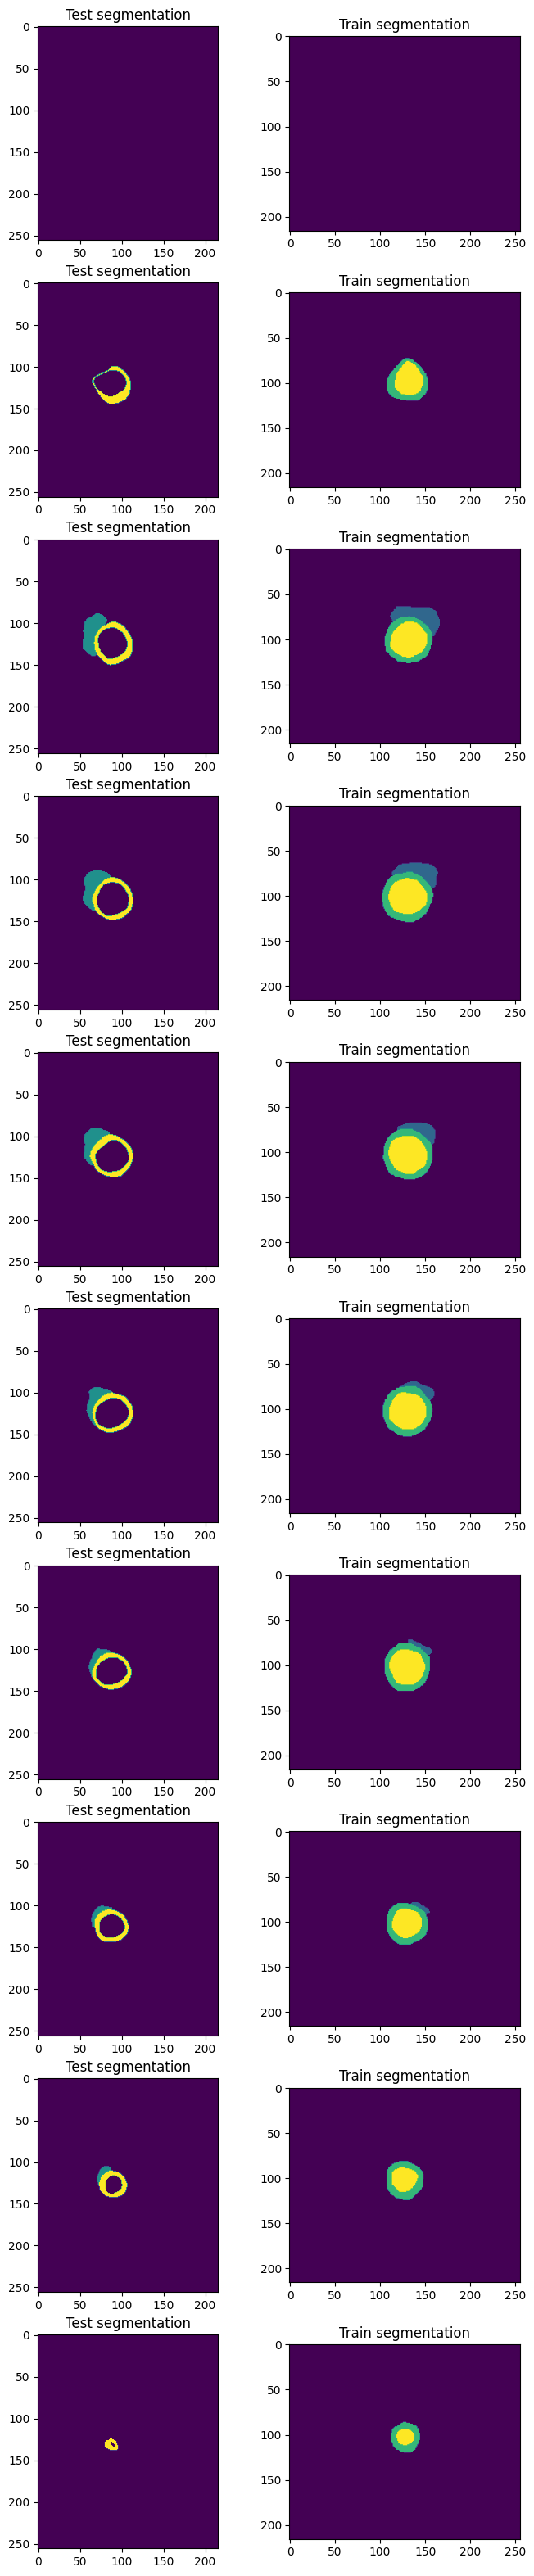

In [36]:
#plotting again 
legend = ["Test segmentation", "Train segmentation"]
seg_level(ES_seg_test, ES_seg_train, legend = legend)

We can see that the only hole present in the test segmented image is the ventricule, and it's inside of the miocardi. We can fill this hole given it the right class pixel number.

In [37]:
from scipy import ndimage as nd

Text(0.5, 1.0, 'Segmented test image')

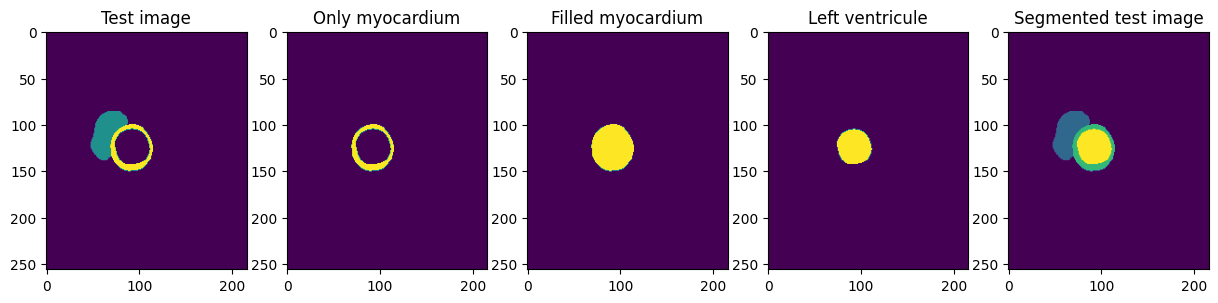

In [38]:
img = ES_seg_test_slice.copy() # copying the img
myo = np.array(img == 2).astype(int) # obtaining an image with the myocardium only 
myo_filled = nd.binary_fill_holes(myo) #filling all the myocardium
left_vent = myo_filled - myo # removing the myocardium
left_vent *= 3 # putting the left ventricule in the right class 
segmented_img = img + left_vent

fig, ax = plt.subplots(1,5, figsize=(15,15))
ax[0].imshow(img)
ax[0].set_title("Test image")
ax[1].imshow(myo)
ax[1].set_title("Only myocardium")
ax[2].imshow(myo_filled)
ax[2].set_title("Filled myocardium")
ax[3].imshow(left_vent)
ax[3].set_title("Left ventricule")
ax[4].imshow(segmented_img)
ax[4].set_title("Segmented test image")


Creating the function to use it in all dataset

In [39]:
def left_ventricle_seg(ES_seg_test):
    ES_full_seg_test = np.zeros(ES_seg_test.shape) # to return the new images
    deep_levels = ES_seg_test.shape[2] # obtaining the number of images
    for level in range(deep_levels):  
        img = ES_seg_test[:,:,level].copy() # #obtaining the respective level image and copying it
        myo = np.array(img == 2).astype(int) # obtaining an image with the myocardium only 
        myo_filled = nd.binary_fill_holes(myo) # filling all the myocardium
        left_vent = myo_filled - myo # removing the myocardium
        left_vent *= 3 # putting the left ventricule in the right class 
        segmented_img = img + left_vent # putting the left_vent with all previous segmented image
        ES_full_seg_test[:,:,level] = segmented_img
    return ES_full_seg_test

## Using the features extraction in all data and making a DataFrame

In [ ]:
# TRAINING DATA INITIALIZATION
# for training data
max_train_id = 100

# initializing arrays of features
#initialization = [np.zeros((max_train_id,))]
#initialization = 
# Perimeter
ED_right_ventriculum_perim = []
ED_left_ventriculum_perim = []
ED_myocardium_perim = []
ES_right_ventriculum_perim = []
ES_left_ventriculum_perim = []
ES_myocardium_perim = []

# Thickness
ES_myocardium_thickness = []
ED_myocardium_thickness = []

# Volume
ED_right_ventriculum_vol = []
ED_left_ventriculum_vol = []
ED_myocardium_vol = []
ES_right_ventriculum_vol = []
ES_left_ventriculum_vol = []
ES_myocardium_vol = []

# Ejection fraction 
EF_right_ventriculum = []
EF_left_ventriculum = []

# Myocardium mass
ED_myocardium_mass = [] 
ES_myocardium_mass = []

# Saving the information after data augmentation
height = [] 
weight = []
category = []

In [ ]:
for id in range(max_train_id):
    #if id%10 == 0
    #    print(f"{id}/{max_train_id}")
    # loading diastole segmentation sample
    ED_babel = nib.load(data_dir + f'/Train/{id+1:03d}/{id+1:03d}_ED_seg.nii')
    # loading systole segmentation sample
    ES_babel = nib.load(data_dir + f'/Train/{id+1:03d}/{id+1:03d}_ES_seg.nii')

    # getting the all images slices (memmap)
    ED_slices = ED_babel.get_fdata()
    ES_slices = ES_babel.get_fdata()

    # dividing the slices for each object
    # diastole
    ED_right_ventriculum = np.array(ED_slices==1).astype(int)
    ED_left_ventriculum = np.array(ED_slices==3).astype(int)  
    ED_myocardium = np.array(ED_slices==2).astype(int)       
    # systole
    ES_right_ventriculum = np.array(ES_slices==1).astype(int)
    ES_left_ventriculum = np.array(ES_slices==3).astype(int)
    ES_myocardium = np.array(ES_slices==2).astype(int)

    #---- Data Augmentation -----


    #---- Features Extraction ------

    # - Perimeter of each object -
    # during diastole    
    ED_right_ventriculum_perim.append(get_max_perim(ED_right_ventriculum))
    ED_left_ventriculum_perim.append(get_max_perim(ED_left_ventriculum))
    ED_myocardium_perim.append(get_max_perim(ED_myocardium))
    # during systole
    ES_right_ventriculum_perim.append(get_max_perim(ES_right_ventriculum))
    ES_left_ventriculum_perim.append(get_max_perim(ES_left_ventriculum))
    ES_myocardium_perim.append(get_max_perim(ES_myocardium))

    # - Myocardium thickness -
    ES_myocardium_thickness.append(ES_myocardium_perim[id] - ES_left_ventriculum_perim[id])
    ED_myocardium_thickness.append(ED_myocardium_perim[id] - ED_left_ventriculum_perim[id])

    # - Volume - 
    ED_voxel_size = np.array(ED_babel.header.get_zooms()) 
    ES_voxel_size = np.array(ES_babel.header.get_zooms())

    # during diastole
    ED_right_ventriculum_vol.append(get_volume(ED_right_ventriculum, ED_voxel_size))
    ED_left_ventriculum_vol.append(get_volume(ED_left_ventriculum, ED_voxel_size))
    ED_myocardium_vol.append(get_volume(ED_myocardium, ED_voxel_size))

    # during systole
    ES_right_ventriculum_vol.append(get_volume(ES_right_ventriculum, ES_voxel_size))  
    ES_left_ventriculum_vol.append(get_volume(ES_left_ventriculum, ES_voxel_size)) 
    ES_myocardium_vol.append(get_volume(ES_myocardium, ES_voxel_size))  

    # - Ejection fraction - 
    # right ventriculum
    if ES_right_ventriculum_vol[id] != 0:
        EF_right_ventriculum.append(get_EF(ED_right_ventriculum_vol[id], ES_right_ventriculum_vol[id]))
    else:
        EF_right_ventriculum.append(0)

    # left ventriculum
    if ES_left_ventriculum_vol[id] != 0:
        EF_left_ventriculum.append(get_EF(ED_left_ventriculum_vol[id], ES_left_ventriculum_vol[id]))
    else:
        EF_left_ventriculum.append(0)

    # - Myocardium mass -
    ED_myocardium_mass.append(get_myo_mass(ED_myocardium_vol[id]))
    ES_myocardium_mass.append(get_myo_mass(ES_myocardium_vol[id]))

In [ ]:
col_features = ['ID',
                'ED RV perimeter (mm)',
                'ED LV perimeter (mm)',
                'ED MYO perimeter (mm)', 
                'ES RV perimeter (mm)',
                'ES LV perimeter (mm)',
                'ES MYO perimeter (mm)', 
                'ES MYO thickness (mm)',
                'ED MYO thickness (mm)',
                'ED RV volume (ml)',
                'ED LV volume (ml)',
                'ED MYO volume (ml)',
                'ES RV volume (ml)',
                'ES LV volume (ml)',
                'ES MYO volume (ml)',
                'ED MYO mass (g)',
                'ES MYO mass (g)',
                'EF RV',
                'EF LV',
                'HEIGHT', 
                'WEIGHT',
                'CATEGORY'           
                ]

In [ ]:
train_DF = pd.DataFrame(columns = col_features)
train_DF

,ID,ED RV perimeter (mm),ED LV perimeter (mm),ED MYO perimeter (mm),ES RV perimeter (mm),ES LV perimeter (mm),ES MYO perimeter (mm),ES MYO thickness (mm),ED MYO thickness (mm),ED RV volume (ml),...,ES RV volume (ml),ES LV volume (ml),ES MYO volume (ml),ED MYO mass (g),ES MYO mass (g),EF RV,EF LV,HEIGHT,WEIGHT,CATEGORY


In [ ]:
train_DF[col_features[0]] = TrainMetaData['Id']
train_DF[col_features[1]] =  ED_right_ventriculum_perim
train_DF[col_features[2]] =  ED_left_ventriculum_perim
train_DF[col_features[3]] =  ED_myocardium_perim
train_DF[col_features[4]] =  ES_right_ventriculum_perim
train_DF[col_features[5]] =  ES_left_ventriculum_perim
train_DF[col_features[6]] =  ES_myocardium_perim
train_DF[col_features[7]] =  ES_myocardium_thickness
train_DF[col_features[8]] =  ED_myocardium_thickness
train_DF[col_features[9]] =   ED_right_ventriculum_vol
train_DF[col_features[10]] =  ED_left_ventriculum_vol
train_DF[col_features[11]] =  ED_myocardium_vol
train_DF[col_features[12]] =  ES_right_ventriculum_vol
train_DF[col_features[13]] =  ES_left_ventriculum_vol
train_DF[col_features[14]] =  ES_myocardium_vol
train_DF[col_features[15]] =  ED_myocardium_mass
train_DF[col_features[16]] =  ES_myocardium_mass
train_DF[col_features[17]] =  EF_right_ventriculum
train_DF[col_features[18]] =  EF_left_ventriculum
train_DF[col_features[19]] = TrainMetaData['Height']
train_DF[col_features[20]] = TrainMetaData['Weight']
train_DF[col_features[21]] = TrainMetaData['Category']


In [ ]:
train_DF

,ID,ED RV perimeter (mm),ED LV perimeter (mm),ED MYO perimeter (mm),ES RV perimeter (mm),ES LV perimeter (mm),ES MYO perimeter (mm),ES MYO thickness (mm),ED MYO thickness (mm),ED RV volume (ml),...,ES RV volume (ml),ES LV volume (ml),ES MYO volume (ml),ED MYO mass (g),ES MYO mass (g),EF RV,EF LV,HEIGHT,WEIGHT,CATEGORY
0,1,29.699931,24.848048,56.612309,24.995892,22.224334,52.226580,30.002245,31.764261,139.721680,...,59.545898,225.610352,195.068359,165.079102,196.043701,0.573825,0.236533,184.0,95.0,2
1,2,27.021604,27.230687,61.975589,24.189777,23.986349,56.930619,32.944269,34.744902,94.432068,...,28.823090,188.303375,192.565155,161.235746,193.527981,0.694774,0.291412,160.0,70.0,2
2,3,28.838233,23.481578,54.213674,28.092386,22.674492,52.863199,30.188707,30.732096,192.333984,...,174.584961,241.088867,201.074219,192.804932,202.079590,0.092282,0.128728,165.0,77.0,2
3,4,28.256226,25.786982,59.538337,27.114835,24.381894,57.403399,33.021504,33.751355,106.264114,...,84.543991,226.472473,174.957275,169.294716,175.832062,0.204398,0.131781,159.0,46.0,2
4,5,32.812421,28.015151,63.885449,29.497474,23.031420,56.409851,33.378432,35.870297,170.463867,...,74.553223,224.094727,232.261963,202.399541,233.423273,0.562645,0.229378,165.0,77.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,30.134094,17.240603,41.024495,29.179164,13.568728,33.378432,19.809703,23.783892,284.093104,...,217.681545,74.905896,115.055796,117.551857,115.631075,0.233767,0.508043,186.0,76.0,4
96,97,33.635503,18.047688,42.561431,28.519923,11.581634,32.516733,20.935099,24.513742,208.836737,...,129.096270,49.664276,110.345472,93.979176,110.897199,0.381832,0.600709,187.0,82.0,4
97,98,35.963528,19.414159,48.615944,33.526276,16.153825,40.481106,24.327281,29.201786,164.656250,...,161.500000,41.187500,102.171875,94.093125,102.682734,0.019169,0.561106,167.0,50.0,4
98,99,26.253136,17.054141,39.301097,22.674492,13.118570,33.285201,20.166631,22.246956,200.365734,...,136.638366,74.058951,92.234883,93.048575,92.696057,0.318055,0.472519,180.0,80.0,4


In [ ]:
train_DF.to_csv(data_dir+'/train_features.csv')

In [ ]:
# TEST DATA INITIALIZATION
# for training data
max_test_id = 150-100

# initializing arrays of features
#initialization = [np.zeros((max_train_id,))]
#initialization = 
# Perimeter
ED_right_ventriculum_perim = []
ED_left_ventriculum_perim = []
ED_myocardium_perim = []
ES_right_ventriculum_perim = []
ES_left_ventriculum_perim = []
ES_myocardium_perim = []

# Thickness
ES_myocardium_thickness = []
ED_myocardium_thickness = []

# Volume
ED_right_ventriculum_vol = []
ED_left_ventriculum_vol = []
ED_myocardium_vol = []
ES_right_ventriculum_vol = []
ES_left_ventriculum_vol = []
ES_myocardium_vol = []

# Ejection fraction 
EF_right_ventriculum = []
EF_left_ventriculum = []

# Myocardium mass
ED_myocardium_mass = [] 
ES_myocardium_mass = []

In [ ]:
for id in range(max_test_id):
    #if id%10 == 0
    #    print(f"{id}/{max_train_id}")
    # loading diastole segmentation sample
    ED_babel = nib.load(data_dir + f'/Test/{id+101:03d}/{id+101:03d}_ED_seg.nii')
    # loading systole segmentation sample
    ES_babel = nib.load(data_dir + f'/Test/{id+101:03d}/{id+101:03d}_ES_seg.nii')

    # getting the all images slices (memmap)
    ED_slices = ED_babel.get_fdata()
    ES_slices = ES_babel.get_fdata()

    # left ventricle segmentation
    ED_slices = left_ventricle_seg(ED_slices)
    ES_slices = left_ventricle_seg(ES_slices)

    # dividing the slices for each object
    # diastole
    ED_right_ventriculum = np.array(ED_slices==1).astype(int)
    ED_left_ventriculum = np.array(ED_slices==3).astype(int)  
    ED_myocardium = np.array(ED_slices==2).astype(int)       
    # systole
    ES_right_ventriculum = np.array(ES_slices==1).astype(int)
    ES_left_ventriculum = np.array(ES_slices==3).astype(int)
    ES_myocardium = np.array(ES_slices==2).astype(int)


    #---- Features Extraction ------

    # - Perimeter of each object -
    # during diastole    
    ED_right_ventriculum_perim.append(get_max_perim(ED_right_ventriculum))
    ED_left_ventriculum_perim.append(get_max_perim(ED_left_ventriculum))
    ED_myocardium_perim.append(get_max_perim(ED_myocardium))
    # during systole
    ES_right_ventriculum_perim.append(get_max_perim(ES_right_ventriculum))
    ES_left_ventriculum_perim.append(get_max_perim(ES_left_ventriculum))
    ES_myocardium_perim.append(get_max_perim(ES_myocardium))

    # - Myocardium thickness -
    ES_myocardium_thickness.append(ES_myocardium_perim[id] - ES_left_ventriculum_perim[id])
    ED_myocardium_thickness.append(ED_myocardium_perim[id] - ED_left_ventriculum_perim[id])

    # - Volume - 
    ED_voxel_size = np.array(ED_babel.header.get_zooms()) 
    ES_voxel_size = np.array(ES_babel.header.get_zooms())

    # during diastole
    ED_right_ventriculum_vol.append(get_volume(ED_right_ventriculum, ED_voxel_size))
    ED_left_ventriculum_vol.append(get_volume(ED_left_ventriculum, ED_voxel_size))
    ED_myocardium_vol.append(get_volume(ED_myocardium, ED_voxel_size))

    # during systole
    ES_right_ventriculum_vol.append(get_volume(ES_right_ventriculum, ES_voxel_size))  
    ES_left_ventriculum_vol.append(get_volume(ES_left_ventriculum, ES_voxel_size)) 
    ES_myocardium_vol.append(get_volume(ES_myocardium, ES_voxel_size))  

    # - Ejection fraction - 
    # right ventriculum
    if ES_right_ventriculum_vol[id] != 0:
        EF_right_ventriculum.append(get_EF(ED_right_ventriculum_vol[id], ES_right_ventriculum_vol[id]))
    else:
        EF_right_ventriculum.append(0)

    # left ventriculum
    if ES_left_ventriculum_vol[id] != 0:
        EF_left_ventriculum.append(get_EF(ED_left_ventriculum_vol[id], ES_left_ventriculum_vol[id]))
    else:
        EF_left_ventriculum.append(0)

    # - Myocardium mass -
    ED_myocardium_mass.append(get_myo_mass(ED_myocardium_vol[id]))
    ES_myocardium_mass.append(get_myo_mass(ES_myocardium_vol[id]))

In [ ]:
test_DF = pd.DataFrame(columns=col_features[:-1])
test_DF

,ID,ED RV perimeter (mm),ED LV perimeter (mm),ED MYO perimeter (mm),ES RV perimeter (mm),ES LV perimeter (mm),ES MYO perimeter (mm),ES MYO thickness (mm),ED MYO thickness (mm),ED RV volume (ml),...,ED MYO volume (ml),ES RV volume (ml),ES LV volume (ml),ES MYO volume (ml),ED MYO mass (g),ES MYO mass (g),EF RV,EF LV,HEIGHT,WEIGHT


In [ ]:
test_DF[col_features[0]] = TestMetaData['Id']
test_DF[col_features[1]] = ED_right_ventriculum_perim
test_DF[col_features[2]] = ED_left_ventriculum_perim
test_DF[col_features[3]] = ED_myocardium_perim
test_DF[col_features[4]] = ES_right_ventriculum_perim
test_DF[col_features[5]] = ES_left_ventriculum_perim
test_DF[col_features[6]] = ES_myocardium_perim
test_DF[col_features[7]] = ES_myocardium_thickness
test_DF[col_features[8]] = ED_myocardium_thickness 
test_DF[col_features[9]] =  ED_right_ventriculum_vol
test_DF[col_features[10]] = ED_left_ventriculum_vol
test_DF[col_features[11]] = ED_myocardium_vol
test_DF[col_features[12]] = ES_right_ventriculum_vol
test_DF[col_features[13]] = ES_left_ventriculum_vol
test_DF[col_features[14]] = ES_myocardium_vol
test_DF[col_features[15]] = ED_myocardium_mass
test_DF[col_features[16]] = ES_myocardium_mass
test_DF[col_features[17]] = EF_right_ventriculum
test_DF[col_features[18]] = EF_left_ventriculum
test_DF[col_features[19]] = TestMetaData['Height']
test_DF[col_features[20]] = TestMetaData['Weight']



In [ ]:
TestMetaData.head(5)

,Id,Height,Weight
0,101,167.0,89.0
1,102,137.0,35.0
2,103,167.0,116.0
3,104,160.0,98.0
4,105,174.0,64.0


In [ ]:
test_DF.head(5)

,ID,ED RV perimeter (mm),ED LV perimeter (mm),ED MYO perimeter (mm),ES RV perimeter (mm),ES LV perimeter (mm),ES MYO perimeter (mm),ES MYO thickness (mm),ED MYO thickness (mm),ED RV volume (ml),...,ED MYO volume (ml),ES RV volume (ml),ES LV volume (ml),ES MYO volume (ml),ED MYO mass (g),ES MYO mass (g),EF RV,EF LV,HEIGHT,WEIGHT
0,101,24.738822,21.439870,49.268560,22.559610,20.275857,46.776694,26.500837,27.828690,143.329510,...,153.584635,84.921052,194.309058,149.924013,154.352558,150.673633,0.407512,0.301365,167.0,89.0
1,102,25.693751,13.568728,29.986250,22.526648,10.494856,24.777439,14.282583,16.417521,169.334610,...,42.457528,98.704197,33.127915,43.250333,42.669816,43.466585,0.417106,0.551810,137.0,35.0
2,103,28.015151,16.285673,38.757708,24.266042,10.906397,31.352720,20.446323,22.472035,172.412109,...,113.867188,94.458008,41.748047,128.100586,114.436523,128.741089,0.452138,0.667380,167.0,116.0
3,104,28.360768,18.140919,45.091914,22.734761,10.813166,34.240131,23.426965,26.950995,147.985239,...,119.629346,55.197728,19.925763,143.349602,120.227492,144.066350,0.627005,0.815603,160.0,98.0
4,105,25.018514,16.005981,37.204776,24.475125,11.131476,28.487931,17.356455,21.198795,222.480845,...,95.915223,167.480013,50.810293,108.033810,96.394799,108.573980,0.247216,0.582771,174.0,64.0


In [ ]:
test_DF.to_csv(data_dir+'/test_features.csv')